# Load Libraries

In [231]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import gensim  # para cargar modelo w2v
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from sklearn.metrics import accuracy_score,roc_curve, auc, confusion_matrix
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import plot_model
import nltk
from nltk.corpus import stopwords
import contractions
from tensorflow.keras.preprocessing.text import Tokenizer # Import from tensorflow.keras.preprocessing
import seaborn as sns

# Load Data

In [232]:
#Load Stop Words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/ola/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [233]:
#Read Data
data = pd.read_csv("deceptive-opinion.csv", usecols=['polarity','text'])
data.head(10)

,polarity,text
0,positive,We stayed for a one night getaway with family ...
1,positive,Triple A rate with upgrade to view room was le...
2,positive,This comes a little late as I'm finally catchi...
3,positive,The Omni Chicago really delivers on all fronts...
4,positive,I asked for a high floor away from the elevato...
5,positive,I stayed at the Omni for one night following a...
6,positive,We stayed in the Conrad for 4 nights just befo...
7,positive,Just got back from 2 days up in Chicago shoppi...
8,positive,We arrived at the Omni on 2nd September for a ...
9,positive,"On our visit to Chicago, we chose the Hyatt du..."


# Text Preprocessing

Los textos de las reseñas fueron procesados para descartar signos de puntuación, números, stopwords, completar contracciones y cambiar las palabras a minúsculas.

La longitud de las reseñas se generalizó en 162 palabras, aquellas reseñas más cortas se completaron con un token PAD. 

In [234]:

# Function to remove punctuation and numbers
def remove_puntuacion(text):
  """Remove puntuación and numbers"""
  new_text = re.sub('[^a-z]+', ' ', text)  
  return new_text  
# Function to remove Stop words
def remove_stopwords(text):
   """Remove Stopwords"""
   stop = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
   new_text= stop.sub('', text)
   return new_text 

def preprocesar(text):
  text= contractions.fix(text)
  text = text.lower()
  text = remove_stopwords(text)
  text = remove_puntuacion(text)
  return(text)

In [235]:
# Convert text to lower case and remove punctuation
data['text_pp'] = data['text'].apply(preprocesar)
# Get lenght of each text review
data['text_pp_len'] = data['text_pp'].str.split().str.len()
data['text_len'] = data['text'].str.split().str.len()
data.head(10)
     

,polarity,text,text_pp,text_pp_len,text_len
0,positive,We stayed for a one night getaway with family ...,stayed one night getaway family thursday tripl...,58,105
1,positive,Triple A rate with upgrade to view room was le...,triple rate upgrade view room less also includ...,30,45
2,positive,This comes a little late as I'm finally catchi...,comes little late finally catching reviews pas...,104,207
3,positive,The Omni Chicago really delivers on all fronts...,omni chicago really delivers fronts spaciousne...,63,127
4,positive,I asked for a high floor away from the elevato...,asked high floor away elevator got room pleasa...,33,72
5,positive,I stayed at the Omni for one night following a...,stayed omni one night following business meeti...,92,183
6,positive,We stayed in the Conrad for 4 nights just befo...,stayed conrad nights thanksgiving corner room ...,59,118
7,positive,Just got back from 2 days up in Chicago shoppi...,got back days chicago shopping girlfriends fir...,68,131
8,positive,We arrived at the Omni on 2nd September for a ...,arrived omni nd september day stay took ill le...,78,164
9,positive,"On our visit to Chicago, we chose the Hyatt du...",visit chicago chose hyatt due location downtow...,49,86


In [236]:
# Get Vocabulary from hotel reviews
def vocabulary(pandas_series):
    word_list = " ".join(sec for sec in pandas_series).split(" ")
    x = Counter(word_list)

    return [i for i,_ in x.most_common() ]

vocabulary_words = vocabulary(data['text_pp'])
vocabulary_words

['hotel',
 'room',
 '',
 'chicago',
 'stay',
 'would',
 'great',
 'staff',
 'service',
 'one',
 'rooms',
 'stayed',
 'us',
 'could',
 'night',
 'like',
 'get',
 'time',
 'desk',
 'nice',
 'location',
 'even',
 'bed',
 'also',
 'clean',
 'good',
 'got',
 'front',
 'back',
 'check',
 'well',
 'place',
 'first',
 'day',
 'bathroom',
 'experience',
 'next',
 'two',
 'really',
 'friendly',
 'comfortable',
 'never',
 'made',
 'hotels',
 'go',
 'recommend',
 'business',
 'lobby',
 'view',
 'staying',
 'much',
 'city',
 'floor',
 'better',
 'area',
 'food',
 'went',
 'breakfast',
 'called',
 'price',
 'best',
 'arrived',
 'definitely',
 'say',
 'restaurant',
 'bar',
 'weekend',
 'everything',
 'told',
 'helpful',
 'found',
 'small',
 'free',
 'trip',
 'make',
 'booked',
 'downtown',
 'right',
 'way',
 'another',
 'asked',
 'beds',
 'beautiful',
 'took',
 'husband',
 'minutes',
 'ever',
 'many',
 'away',
 'people',
 'door',
 'water',
 'reservation',
 'hilton',
 'nights',
 'wonderful',
 'morning

In [237]:
# Count vocabulary  Unique words
len(vocabulary_words)

9133

In [238]:
# Save words as tokens
data['tokens'] = data['text_pp'].str.split()

<Axes: >

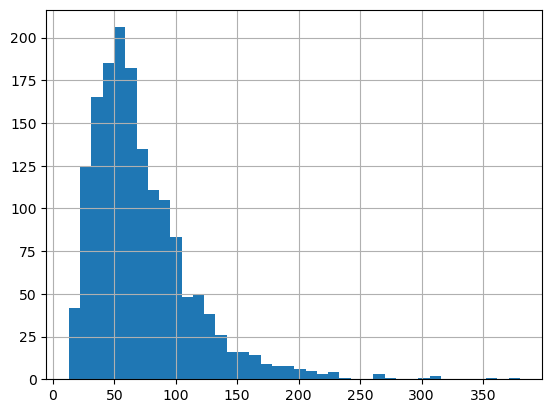

In [239]:
#Histogram with reviews lenght
data['text_pp_len'].hist(bins=40) 

In [240]:
# Estimate percentiles for the variable text_len
custom_percentiles = list(range(5, 101,5))
custom_percentile_values = np.percentile(data['text_pp_len'], custom_percentiles)
percentile_table = pd.DataFrame({
    'Percentile': custom_percentiles,
    'Value': custom_percentile_values
})
print(percentile_table)

    Percentile   Value
0            5   26.00
1           10   31.00
2           15   36.00
3           20   40.00
4           25   45.00
5           30   48.00
6           35   51.00
7           40   55.00
8           45   58.00
9           50   63.00
10          55   67.00
11          60   72.00
12          65   77.35
13          70   83.00
14          75   90.00
15          80   97.20
16          85  108.00
17          90  124.00
18          95  153.00
19         100  380.00


In [241]:
# Define max lenght for reviews
max_len = int(data['text_pp_len'].quantile(0.96))
max_len

162

In [242]:
#View Data
data.head(10)

,polarity,text,text_pp,text_pp_len,text_len,tokens
0,positive,We stayed for a one night getaway with family ...,stayed one night getaway family thursday tripl...,58,105,"[stayed, one, night, getaway, family, thursday..."
1,positive,Triple A rate with upgrade to view room was le...,triple rate upgrade view room less also includ...,30,45,"[triple, rate, upgrade, view, room, less, also..."
2,positive,This comes a little late as I'm finally catchi...,comes little late finally catching reviews pas...,104,207,"[comes, little, late, finally, catching, revie..."
3,positive,The Omni Chicago really delivers on all fronts...,omni chicago really delivers fronts spaciousne...,63,127,"[omni, chicago, really, delivers, fronts, spac..."
4,positive,I asked for a high floor away from the elevato...,asked high floor away elevator got room pleasa...,33,72,"[asked, high, floor, away, elevator, got, room..."
5,positive,I stayed at the Omni for one night following a...,stayed omni one night following business meeti...,92,183,"[stayed, omni, one, night, following, business..."
6,positive,We stayed in the Conrad for 4 nights just befo...,stayed conrad nights thanksgiving corner room ...,59,118,"[stayed, conrad, nights, thanksgiving, corner,..."
7,positive,Just got back from 2 days up in Chicago shoppi...,got back days chicago shopping girlfriends fir...,68,131,"[got, back, days, chicago, shopping, girlfrien..."
8,positive,We arrived at the Omni on 2nd September for a ...,arrived omni nd september day stay took ill le...,78,164,"[arrived, omni, nd, september, day, stay, took..."
9,positive,"On our visit to Chicago, we chose the Hyatt du...",visit chicago chose hyatt due location downtow...,49,86,"[visit, chicago, chose, hyatt, due, location, ..."


# Use trained Word2Vec to map words into vectors
 Code is commented after saving pikle object with the word embeddings present in the vocabulary of the hotel reviews.

In [243]:
# Load Word2Vec
#file =  '/home/ola/Documents/ubuntu/mydsportafolio/rnn_classifier/notes/GoogleNews-vectors-negative300.bin.gz'
#w2v = gensim.models.KeyedVectors.load_word2vec_format(file,  binary=True)


# Convert each text into a sequence of tokens 

In [244]:
#dic_tokens = Tokenizer()
#dic_tokens.fit_on_texts(data['tokens'])

# Save embeddings from word2vec present in the hotel reviews
#dic_tokens.word_index = {word: idx for word, idx in dic_tokens.word_index.items() if word in w2v}
#words_no_embedding = [token for token in vocabulary_words if token not in dic_tokens.word_index]
#print(f' Words with embedding in word2Vec {len(dic_tokens.word_index)}')
#print(f' Words no embedding in word2Vec {len(words_no_embedding )}')
# Count vocabulary  Unique words
#print(f' Total unique Words in vocabulary {len(vocabulary_words)}')


In [245]:
# Create Dictionary with embeddings
#dic_tokens_word2vec  = {}
#for token in vocabulary_words:
#   try:
#     dic_tokens_word2vec[token] = w2v[token]
#   except:
#     words_no_embedding.append(token)

In [246]:
# Save embeddings into pickle object
#import pickle
#path = '/home/ola/Documents/ubuntu/mydsportafolio/rnn_classifier/notes/Pikles'
#pickle.dump(dic_tokens, open (path + "dic_tokens_in_w2v.pkl", 'wb'))
#pickle.dump(dic_tokens_word2vec, open (path + "dic_tokens_embeddings_w2v.pkl", 'wb'))

In [247]:
# Load embeddings into pickle object
import pickle
path = '/home/ola/Documents/ubuntu/mydsportafolio/rnn_classifier/notes/Pikles'
dic_tokens_word2vec = pickle.load(open(path + "dic_tokens_embeddings_w2v.pkl", 'rb'))
dic_tokens = pickle.load(open(path + "dic_tokens_in_w2v.pkl", 'rb'))


In [ ]:
# Padding, add Pad Token to make reviews of the same length
data['seqs'] = dic_tokens.texts_to_sequences(data['tokens'])
pad_tokens = pad_sequences(data['seqs'], maxlen= max_len,padding='post',
                           value = 0)

# Load embeddings from word2vec present in the hotel reviews

In [249]:
#Get Embeddings Matrix
num_words = len(vocabulary_words)
print(num_words)
embedding_dim = 300
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in dic_tokens.word_index.items():
    if word in dic_tokens_word2vec.keys():
       embedding_matrix[i] = dic_tokens_word2vec[word]

9133


In [250]:
#View embedding matrix
pd.DataFrame(embedding_matrix)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.026123,0.014404,-0.034424,-0.005829,0.026978,0.051514,-0.123047,-0.289062,0.339844,-0.027100,...,-0.053955,0.096191,0.138672,0.194336,0.108398,-0.191406,-0.131836,0.156250,0.099609,0.126953
2,0.026245,0.132812,-0.023438,0.091309,0.018066,0.039062,-0.039307,-0.086914,0.195312,-0.036377,...,-0.169922,0.073242,0.048340,0.024292,-0.038818,-0.445312,-0.078613,0.121582,-0.132812,0.103027
3,-0.134766,0.181641,0.093262,0.414062,-0.130859,0.294922,-0.378906,-0.211914,0.051025,0.036133,...,0.080566,0.294922,-0.057861,0.134766,0.058838,-0.187500,-0.176758,-0.441406,-0.007812,0.006744
4,-0.009583,-0.084473,-0.108887,0.209961,0.012512,0.126953,0.045898,-0.093750,0.058350,-0.203125,...,-0.109375,0.412109,-0.115234,0.139648,0.111816,-0.058350,-0.050293,0.018433,0.242188,-0.019287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9128,-0.036865,0.205078,0.086914,-0.051758,0.067871,0.092285,-0.027466,0.390625,0.474609,0.259766,...,0.054932,0.023071,0.182617,0.154297,-0.263672,0.285156,-0.228516,0.061523,-0.026978,0.204102
9129,0.001266,0.014221,-0.071777,-0.248047,-0.314453,0.054932,0.189453,-0.139648,0.417969,0.259766,...,0.193359,0.168945,-0.024536,-0.034180,-0.090820,-0.361328,0.335938,-0.019287,0.123535,0.005188
9130,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9131,0.082031,0.250000,-0.070312,0.108887,-0.130859,0.026855,-0.009705,-0.035156,-0.125977,-0.238281,...,0.100586,-0.249023,0.123047,-0.016235,-0.175781,-0.091309,-0.128906,-0.036865,-0.078613,0.161133


# Encode target variable

In [251]:
data['polarity_label'] = np.where(data['polarity']=='positive', 1, 0)
data['polarity_label'].value_counts()


polarity_label
1    800
0    800
Name: count, dtype: int64

In [252]:

y = data['polarity_label']
y.head(4)

0    1
1    1
2    1
3    1
Name: polarity_label, dtype: int64

# Split Data in training and testing

In [288]:
train_tokens, test_tokens, train_y, test_y = train_test_split(pad_tokens, y, test_size=0.2)

print("TRAINING SET")
print("X: ", train_tokens.shape)
print("y: ", train_y.shape)
print('Positive Reviews:{:.5f}%'.format(train_y.mean()*100),'\n')

print("TEST SET")
print("X: ", test_tokens.shape)
print("y: ", test_y.shape)
print('Positive Reviews:{:.5f}%'.format(test_y.mean()*100))


TRAINING SET
X:  (1280, 162)
y:  (1280,)
Positive Reviews:50.46875% 

TEST SET
X:  (320, 162)
y:  (320,)
Positive Reviews:48.12500%


In [254]:
print(y)

0       1
1       1
2       1
3       1
4       1
       ..
1595    0
1596    0
1597    0
1598    0
1599    0
Name: polarity_label, Length: 1600, dtype: int64


# Building neural network

La red neuronal recurrente de muchas entradas (secuencia de palabras) a una predicción de clase categorica (sí la reseña es positiva o negativa), se diseño con la siguiente arquitecura:
- **Input_layer**: Se declara el tamañp tensor [Bath size ,  palabras por cada reseña = 162].
- **Embedding layer** : Capa con la matriz de encajes, tiene 300 columnas y 9133 filas. La salida de esa capa será un tensor de tres dimensiones que alimenta a la capa LSTM [Bath size , timesteps = 162, features = 300].
- **LSTM_layer**: Capa que recibe los embeddings y que genera 128 salidas [Bath size , units = 128].
- **DenseOutput_layer**: Capa que genera 1 salida con la probabilidad de que una secuencia de palabras pertenezca a una reseña positiva o negativa. Su salida corresponde a un tensor  [Bath size , 1]. La función de activación utiliza una sigmoide

In [276]:
# Layer Input
Input_layer = Input(shape = (max_len,))

#Layer embedding
Embedding_layer = Embedding(input_dim = num_words,
                      output_dim = 300,
                      weights = [embedding_matrix],
                      
                      trainable=False)

# Layer LSTM 
LSTM_layer = LSTM( units=128)  
# Layer Dense
DenseOutput_layer = Dense(1,   # 
          activation="sigmoid"  # para obtener una probabilidad para cada clase https://www.tensorflow.org/api_docs/python/tf/keras/activations
          )

RNN_model = Sequential()
RNN_model.add(Input_layer)
RNN_model.add(Embedding_layer)
RNN_model.add(LSTM_layer)
RNN_model.add(DenseOutput_layer)
                    

In [277]:
# Compile model
RNN_model.compile(optimizer='adam',         # el optimizador sirve para encontrar los pesos que minimizan la función de pérdida
                                            # adam: stochastic gradient descent adaptativo
                                            # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
                  loss="binary_crossentropy", # función que evalua que tan bien el algoritmo modela el conjunto de datos
                                                   # https://www.tensorflow.org/api_docs/python/tf/keras/losses
                  metrics=['auc'])

In [278]:
RNN_model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 162, 300)       │     2,739,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 128)            │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,959,677 (11.29 MB)

 Trainable params: 219,777 (858.50 KB)

 Non-trainable params: 2,739,900 (10.45 MB)

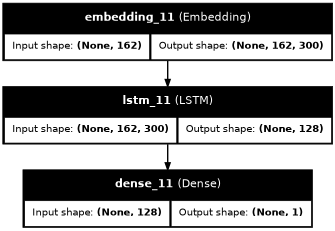

In [279]:
plot_model(
    RNN_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=50,
)

# Model training
La metrica de evaluación del modelo es el área bajo la curva roc (auc).

In [280]:
history = RNN_model.fit(train_tokens, train_y,                        
                        validation_data=(test_tokens, test_y),
                        batch_size=300,
                        epochs=10,   # número de iteraciones sobre los datos
                        verbose=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 818ms/step - auc: 0.5201 - loss: 0.6897 - val_auc: 0.5502 - val_loss: 0.6884
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 807ms/step - auc: 0.5504 - loss: 0.6807 - val_auc: 0.6432 - val_loss: 0.6872
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 760ms/step - auc: 0.6225 - loss: 0.6750 - val_auc: 0.7075 - val_loss: 0.6789
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 738ms/step - auc: 0.6641 - loss: 0.6586 - val_auc: 0.7242 - val_loss: 0.6857
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 745ms/step - auc: 0.6999 - loss: 0.6395 - val_auc: 0.8876 - val_loss: 0.7383
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 805ms/step - auc: 0.8456 - loss: 0.5544 - val_auc: 0.9291 - val_loss: 0.3410
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 741ms/step - auc: 0.9116 - loss: 0.3566 - val_auc: 0.9356 - val_loss: 0.4166
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 864ms/step - auc: 0.9243 - loss: 0.3863 - val_auc: 0.9214 - val_loss: 0.4390
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 858ms/step - auc: 0.9221 - loss: 

# Model Evaluation 
La red neuronal recurrente muestra un desempeño ligeramente mayor en el set de entrenamiento (auc = 0.95) que en el set de prueba (auc =0.93).

# Training set

In [281]:
def grafica_roc_train(clf, y_train):
    '''Plot ROCcurve for training set'''
    y_train_score = clf.predict(np.array(train_tokens))
    fpr, tpr, _ = roc_curve( y_train, y_train_score)
    roc_auc = auc(fpr, tpr)  #Area bajo la curva (AUC, por sus siglas en inglés)
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve(area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], "--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate ")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step


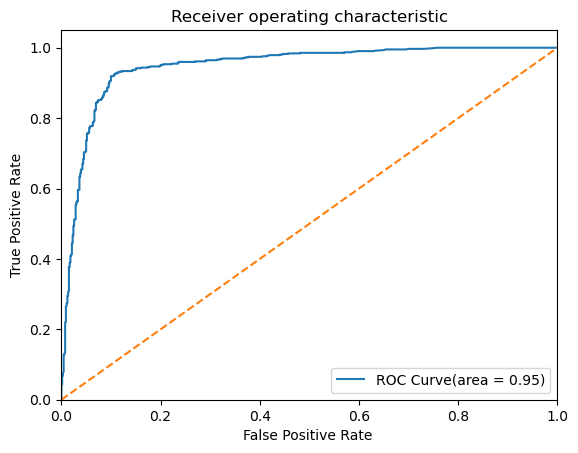

In [282]:
grafica_roc_train(RNN_model, train_y)

# Testing set

In [283]:
def grafica_roc_test(clf, y_test):
    '''Plot ROCcurve for testing set'''
    y_test_score = clf.predict(np.array(test_tokens))
    fpr, tpr, thresholds = roc_curve( y_test, y_test_score)
    roc_auc = auc(fpr, tpr)  #Area bajo la curva (AUC, por sus siglas en inglés)
    roc_df = pd.DataFrame({'fpr': fpr,
                       'tpr':tpr,
                       'cutoff': thresholds,
                       'distance': np.sqrt((fpr)**2 + (1-tpr)**2),
                       })
    
    print(f'Optimal cutoff {roc_df.sort_values('distance').head(1)}')
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve(area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], "--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate ")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
Optimal cutoff          fpr       tpr    cutoff  distance
45  0.079137  0.895028  0.579647   0.13146


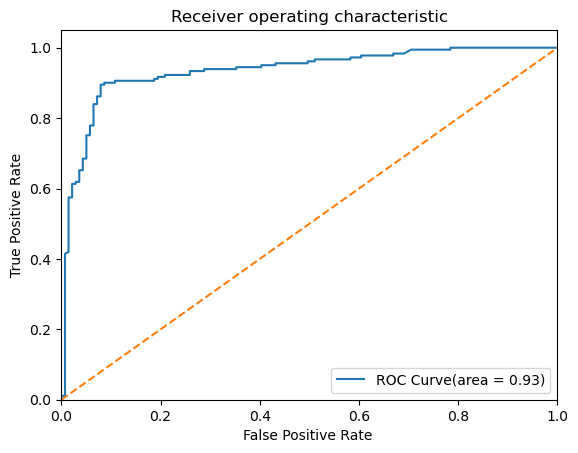

In [284]:
grafica_roc_test(RNN_model, test_y)

## Cutoff selection for optimal false positive and true positive rates

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


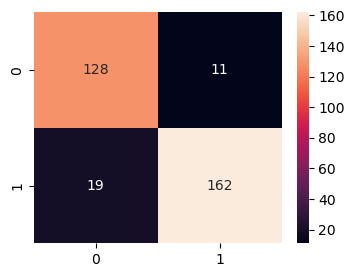

In [287]:
# Cutoff
cutoff = 0.57
## Evaluar con matriz de confusión
y_pred = (RNN_model.predict(test_tokens) > cutoff).astype("int32")
conf_mtx = confusion_matrix(test_y, y_pred)

fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap(conf_mtx, annot=True, fmt='g')
plt.show()


# Resumen Ejecutivo
